In [17]:
# the bigwig files I used were from potter et al 2018 NaOH treatment https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116287 called GSE116287_Roots_NaOH_Merged.bw and GSE116287_Shoots_NaOH_Merged.bw
# had to install "conda install -c conda-forge tqdm" too

# NOTE - if using genbank files from Benchling, first add custom fields on the metadata page with the start and end index (eg. start_index 6015558)
# also ensure the name of the genebank file (and sequence id) include the AGI locus name enclosed in parentheses(eg. "(AT4G24020)")
# This is so the chromosome number can be extracted
# This is to ensure the start and end chromosome positions open chromatin data
# make sure when exporting the .gb file from Benchling that you do not tick "Convert Non-Standard Annotation Types"
# I merged bigwig files with DNaseseq data from Sullivan et al 2014 using WiggleTools (not shown in this notebook)

# import modules
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
import matplotlib.text as mtext
import os

# only import class if in TRAMP directory
try:
    import class_customtranslator
except ModuleNotFoundError:
    from src.TRAMP import class_customtranslator

# import matplotlib as mpl
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import (
    SeqFeature,
    FeatureLocation,
    ExactPosition,
    BeforePosition,
    AfterPosition,
    BetweenPosition,
    WithinPosition,
    CompoundLocation,
)

import numpy as np

# allows custom colours
from dna_features_viewer import BiopythonTranslator
from itertools import cycle
import re

# allow converting from RGB to CMYK
from PIL import Image
import pygenometracks.tracks as pygtk

# note  - use conda env gene_feature_plot

In [18]:
# # create a class specifying feature colours
# # make feature_list and colour_dict so that each feature name and colour is only added once to legend if more than one share the same name
# feature_list = []
# colour_dict = {}
# # set probe_labels on or off here
# probe_labels = False


# class MyCustomTranslator(BiopythonTranslator):
#     """Custom translator iplementing the following theme:
#     -Colour promoter in pale green
#     -colour exons in dark grey
#     -colour introns in light grey
#     -colour TFs from colour palette"""
    
#     colour_list = [
#         "#2271B2",  # ARF9/18
#         "#3DB7E9",  # ANR1
#         "#F748A5",  # TGA1
#         "#d55e00",  # ANAC032
#         "#228833",  # NLP6/7
#         "#e69f00",  # DREB26
#         "#900000",
#     ]
#     #make colour iterator
#     colour_iterator=cycle(colour_list)
    
#     def compute_feature_color(self, feature):
#         """set colour of each feature"""

#         if feature.type == "promoter":
#             return "#F5F5F5"
#         elif feature.type == "gene_upstream":
#             return "#DDCC77"  # dark slate grey
#         elif feature.type == "mRNA_upstream":
#             return "#DDCC77"  # dark slate grey
#         elif feature.type == "exon_upstream":
#             return "#DDCC77"  # dark slate grey
#         elif feature.type == "exon":
#             return "#635147"  # umber
#         elif feature.type == "gene":
#             return "#F5F5F5"
#         elif feature.type == "intron":
#             return "lightgrey"
#         elif feature.type == "5'UTR":
#             return "c4aead"  # silver pink
#         elif feature.type == "start_codon":
#             return "black"

#         elif feature.type == "TFBS":
#             if feature.qualifiers.get("label")[0] in colour_dict.keys():
#                 col = colour_dict[feature.qualifiers.get("label")[0]]
#             else:
#                 col = next(self.colour_iterator)
#                 colour_dict[feature.qualifiers.get("label")[0]] = col

#             return col
#         else:
#             return "white"

#     def compute_feature_box_linewidth(self, feature):
#         """change shape of features"""
#         if feature.type == "TRAMP_probe_tested":
#             if probe_labels:  # if probe labels = True, add probe labels
#                 print("probe labels = True")
#                 return 1
#         else:
#             return 0

#     def compute_feature_linewidth(self, feature):
#         """change linewidth of feature's arrow/rectangle"""
#         # remove border from certain features
#         if feature.type == "gene_upstream":
#             return 0
#         elif feature.type == "mRNA_upstream":
#             return 0
#         elif feature.type == "exon_upstream":
#             return 0
#         elif feature.type == "misc_RNA_upstream":
#             return 0
#         elif feature.type == "exon":
#             return 0
#         elif feature.type == "intron":
#             return 0
#         elif feature.type == "5'UTR":
#             return 0
#         elif feature.type == "TFBS":
#             return 0
#         elif feature.type == "TRAMP_probe_tested":
#             if probe_labels:
#                 # if probe labels = True, add probe labels
#                 return 2
#             elif not probe_labels:
#                 return 0
#         return 0
   
#     def compute_feature_box_color(self, feature):
#         """change colour of feature box border"""
#         if feature.type == "TRAMP_probe_tested":
#             if feature.qualifiers.get("label")[0] == "NLP7#7":
#                 # col = colour_dict["NLP6/7"]
#                 col = "#228833"
#             elif feature.qualifiers.get("label")[0] == "NLP7#9":
#                 # col = colour_dict["DREB26"]
#                 col = "#e69f00"
#             elif feature.qualifiers.get("label")[0] == "NLP7#10":
#                 # col = colour_dict["ANAC032*"]
#                 col = "#d55e00"
#             elif feature.qualifiers.get("label")[0] == "ANAC032#4":
#                 # col = colour_dict["ANAC032*"]
#                 col = "#d55e00"
#             elif feature.qualifiers.get("label")[0] == "ANAC032#8":
#                 # col = colour_dict["ARF9/18*"]
#                 col = "#2271B2"
#             elif feature.qualifiers.get("label")[0] == "ANAC032#3":
#                 # col = colour_dict["TGA1"]
#                 col = "#F748A5"
#             else:
#                 return "black"

#             return col

#     def compute_feature_open_left(self, feature):
#         """set to true if feature does not end on the left"""
#         return False

#     def compute_feature_open_right(self, feature):
#         """set to true if feature does not end on the right"""
#         return False

#     def compute_feature_label(self, feature):
#         """Remove most feature labels"""
#         if feature.type == 'start_codon':
#             return "ATG"
#         if feature.type == 'TRAMP_probe_tested':
#             if probe_labels is True:
#                 return feature.qualifiers.get("label")[0]     
#         else:
#             pass

#     def compute_feature_fontdict(self, feature):
#         """change label font to arial, size to 10"""
#         if feature.type == "TRAMP_probe_tested":
#             # if certain label, align to the right
#             if feature.qualifiers.get("label")[0] == "ANAC032#3":
#                 return dict(family="sans-serif", size=10, ha="right")
#             if feature.qualifiers.get("label")[0] == "ANAC032#8":
#                 return dict(family="sans-serif", size=10)
#             else:
#                 return dict(family="sans-serif", size=10)

#         else:
#             return dict(family="sans-serif", size=10)

#     def compute_feature_legend_text(self, feature):
#         """add legend if feature label has not been added to legend already"""
#         if feature.type == "promoter":
#             pass

#         elif feature.qualifiers.get("label")[0] in feature_list:
#             pass
#         else:

#             feature_list.append(feature.qualifiers.get("label")[0])

#             return feature.qualifiers.get("label")[0]  


#     def compute_filtered_features(self, features):
#         """Displays feature if feature is not one of the following"""
#         if probe_labels is True:
#             return [
#                 feature
#                 for feature in features
#                 if (feature.type != "TRAMP_probe")
#                 and (feature.type != "none")
#                 and (feature.type != "DHS")
#                 and (feature.type != "misc_feature")
#                 and (feature.type != "primer")
#                 and (feature.type != "mRNA")
#                 and (feature.type != "CDS")
#                 and (feature.type != "source")
#                 and (feature.type != "misc_RNA")
#                 and (feature.type != "EMSA_probe_long")
#                 and (
#                     feature.qualifiers.get("label")[0] != "ARID5_ARID6"
#                     and (feature.qualifiers.get("label")[0] != "ARDI5_ARID6")
#                     and (
#                         "Translation" not in feature.qualifiers.get("label")[0]
#                     )
#                     # return feature only if it is one of the following:
#                     and (
#                         (feature.type == "promoter")
#                         or (feature.type == "TFBS")
#                         or (feature.type == "exon")
#                         or (feature.type == "intron")
#                         or (feature.type == "start_codon")
#                         or (feature.type == "gene")
#                         or (feature.type == "exon_upstream")
#                         or (feature.type == "mRNA_upstream")
#                         or (feature.type == "gene_upstream")
#                         or (feature.type == "misc_RNA_upstream")
#                         or (feature.type == "5'UTR")
#                         or (feature.type == "TRAMP_probe_tested")
#                     )
#                 )
#             ]
#         else:

#             return [
#                 feature
#                 for feature in features
#                 if (feature.type != "TRAMP_probe")
#                 and (feature.type != "TRAMP_probe_tested")
#                 and (feature.type != "none")
#                 and (feature.type != "DHS")
#                 and (feature.type != "misc_feature")
#                 and (feature.type != "primer")
#                 and (feature.type != "mRNA")
#                 and (feature.type != "CDS")
#                 and (feature.type != "source")
#                 and (feature.type != "misc_RNA")
#                 and (feature.type != "EMSA_probe_long")
#                 and (
#                     feature.qualifiers.get("label")[0] != "ARID5_ARID6"
#                     and (feature.qualifiers.get("label")[0] != "ARDI5_ARID6")
#                     and (
#                         "Translation" not in feature.qualifiers.get("label")[0]
#                     )
#                     # return feature only if it is one of the following:
#                     and (
#                         (feature.type == "promoter")
#                         or (feature.type == "TFBS")
#                         or (feature.type == "exon")
#                         or (feature.type == "intron")
#                         or (feature.type == "start_codon")
#                         or (feature.type == "gene")
#                         or (feature.type == "exon_upstream")
#                         or (feature.type == "mRNA_upstream")
#                         or (feature.type == "gene_upstream")
#                         or (feature.type == "misc_RNA_upstream")
#                         or (feature.type == "5'UTR")
#                     )
#                 )
#             ]

In [19]:
# code from https://github.com/biopython/biopython/blob/c733feb84e7c48a54921f2c2ace2c57efdd97c8c/Bio/SeqUtils/SeqSlicerWithFeatures.py
# this allows slicing of a sequence while keeping truncated annotations

def move_position(pos, move: int, keep_all: bool, slice_len: int):
    tt = type(pos)
    if isinstance(pos, (ExactPosition, BeforePosition, AfterPosition)):
        if int(pos) + move < 0:
            return BeforePosition(0)
        elif int(pos) + move > slice_len:
            return AfterPosition(slice_len)
        else:
            return tt(pos + move)
    elif isinstance(pos, (BetweenPosition, WithinPosition)):
        # This would need updating if BetweenPosition or WithinPosition gets obsolete or changed
        # attributes accessed because they are not exposed in any other way
        diff_left = pos._left + move
        diff_right = pos._right + move

        if diff_left < 0 and diff_right <= 0:
            return BeforePosition(0)
        elif diff_left < 0 < diff_right:
            if keep_all:
                tt(0, 0, pos._right)
            else:
                return None
        elif diff_left > 0 and diff_right > 0:
            if diff_left < slice_len and diff_right < slice_len:
                return AfterPosition(slice_len)
            elif diff_left < slice_len < diff_right:
                if keep_all:
                    return tt(slice_len, diff_left, slice_len)
                else:
                    return None
            else:
                # This should not be reached
                raise ValueError
        else:
            # This should not be reached
            raise ValueError
    else:
        # raise for not known Position classes
        raise NotImplementedError(
            "slicing for position {} not implemented".format(type(pos))
        )


def start_violation_pos(x, sl: slice):
    return x.start.position < sl.start < x.end.position


def end_violation_pos(x, sl: slice):
    return x.start.position < sl.stop < x.end.position

def slice_feature(
    feature: FeatureLocation, sl: slice, keep_all_features: bool, seq_len: int
):
    if isinstance(feature, CompoundLocation):
        of = []
        for ff in feature.parts:
            # this must be without location boundaries checking
            #  - only location objects adjacent to slice boundaries can cross it

            # However we need to check whether the location object is fully inside the slice
            #  (and discard those which are not)

            mps = move_position(
                ff.start, -sl.start, keep_all_features, seq_len
            )
            mpe = move_position(ff.end, -sl.start, keep_all_features, seq_len)
            if mps is not None and mpe is not None:
                fl = FeatureLocation(mps, mpe, ff.strand)

            # Feature locations outside of slice gets discarded
            if fl is not None:
                of.append(fl)

        return CompoundLocation(of, operator=feature.operator)
    else:
        if start_violation_pos(feature, sl) or end_violation_pos(feature, sl):

            mps = move_position(
                feature.start, -sl.start, keep_all_features, seq_len
            )
            mpe = move_position(
                feature.end, -sl.start, keep_all_features, seq_len
            )

            if mps is not None and mpe is not None:

                fl = FeatureLocation(mps, mpe, feature.strand)
                return fl
            else:
                return None
        else:
            return None

def slice_sequence_with_features(
    seq: SeqRecord, sl: slice, keep_all_features: bool = False
) -> SeqRecord:
    """
    This is an attempt to make slicing function for Bio.Seq which retains features which are not fully in slice
      it is intended for visualization purposes where part of a feature also provides valuable information
    # location variants:
    - CompoundLocation - Collection of FeatureLocation objects (for joins etc).             ? -> solved
    - ExactPosition - Specify the position as being exact.                                  OK
    - WithinPosition - Specify a position occurring within some range.                      ? -> solved
    - BetweenPosition - Specify a position occurring between a range (OBSOLETE?).           ? -> solved
    - BeforePosition - Specify the position as being found before some base.                OK
    - AfterPosition - Specify the position as being found after some base.                  OK
    - OneOfPosition - Specify a position where the location can be multiple positions.      ? Not is spec ? -> raise
    - UnknownPosition - Represents missing information like '?' in UniProt.                 raise
    """
    ns = seq[sl.start : sl.stop]

    seq_len = len(ns)
    for feat in seq.features:
        fl = slice_feature(feat.location, sl, keep_all_features, seq_len)
        if fl is not None:
            nf = SeqFeature(
                fl,
                type=feat.type,
                id=feat.id,
                qualifiers=feat.qualifiers,
                ref=feat.ref,
                ref_db=feat.ref_db,
            )
            ns.features.append(nf)

    return ns

In [20]:

def preprocess_record(seqrecord, promoter_name, bp_downstream_of_TSS):
    """Preprocess the biopython record before feeding it into the translator."""

    # shorten the seqrecord to only a certain length after the TSS
    for feature in seqrecord.features:
        # if feature.type == 'source':
        #     old_start = feature.location.start
        #     old_end = feature.location.end

        if feature.type == "promoter":
            # start at beginning of the promoter, end a certain length after the end of the promoter
            start = feature.location.start
            promoter_end = feature.location.end
            end = promoter_end + (bp_downstream_of_TSS - 1)
    # cycle through features, keeping the index information
    # then rename upstream genes that are upstream of the transcription start site (end of promoter)

    def rename_upstream_features(TSS_location, feature_name, seqrecord):
        """function to rename features that are upstream of the transcription start site (end of promoter)"""

        for idx, feature in enumerate(seqrecord.features):
            if feature.type == feature_name:
                # if gene is upstream of the TSS, rename feature to gene_upstream
                feature_start = feature.location.start
                feature_end = feature.location.end
                feature_qualifiers = feature.qualifiers
                if feature_start < TSS_location:
                    seqrecord.features[idx] = SeqFeature(
                        FeatureLocation(feature_start, feature_end),
                        type=f"{feature_name}_upstream",
                        qualifiers=feature_qualifiers,
                    ) 

   # rename upstream features
    rename_upstream_features(promoter_end, "gene", seqrecord)
    rename_upstream_features(promoter_end, "exon", seqrecord)
    # rename_upstream_features(promoter_end,'misc_RNA',seqrecord)
    rename_upstream_features(promoter_end, "mRNA", seqrecord)
    rename_upstream_features(promoter_end, "CDS", seqrecord)
            
    #slice the seqrecord using the new start and end, keeping truncated annotations
    shortened_seqrecord = slice_sequence_with_features(
        seqrecord, slice(start, end)
    )
    #add meta data
    shortened_seqrecord.id = seqrecord.id + "_shortened"
    shortened_seqrecord.annotations = seqrecord.annotations
    # shorten the annotations start and end locations
    keywords = shortened_seqrecord.annotations["keywords"][0]
    # print(f'keywords = {keywords}')
    old_start_index = int(re.findall(r"start_index:(\d+)", keywords)[0])

    new_start_index = old_start_index + start
    new_end_index = old_start_index + end

    new_keywords = [
        f'"end_index:{new_end_index}" "start_index:{new_start_index}"'
    ]

    shortened_seqrecord.annotations["keywords"] = new_keywords
    # save shortened seq_record named after its ID if file doesn't exist
    file_location = f"../../data/TRAMP/{promoter_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS.gb"

    if os.path.exists(file_location) is False:
        SeqIO.write(shortened_seqrecord, file_location, "genbank")
    elif os.path.exists(file_location) is True:
        print(
            f"{promoter_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS.gb already exists"
        )
    
    # Ensure that genbank files are reverse complemented so that plots can be aligned to the right in figure
    new_seqrecord = shortened_seqrecord.reverse_complement(
        id=shortened_seqrecord.id + "_rc"
    )
    
    for feature in new_seqrecord.features:
        # change strand to None so that features are rectangular
        feature.location.strand = None

        if feature.type == "TFBS":
            # print(feature)
            # change sigil to box
            feature.qualifiers["sigil"] = "OCTAGON"
            # increase width of TFBS so colour is more visible
            TFBS_start = feature.location.start
            TFBS_end = feature.location.end
            # find middle of TFBS
            middle = (
                TFBS_end - TFBS_start
            ) // 2  # floor division creating an integer

            new_start = TFBS_start - 8 + middle
            new_end = TFBS_end - middle + 8
            feature.location = FeatureLocation(new_start, new_end)
            # change name of some TFBSs
            if feature.qualifiers.get("label")[0] == "ANR1_AGL16":
                feature.qualifiers.get("label")[0] = "ANR1*"
            elif feature.qualifiers.get("label")[0] == "ANAC032_NAC002":
                feature.qualifiers.get("label")[0] = "ANAC032*"
            elif feature.qualifiers.get("label")[0] == "ANAC032":
                feature.qualifiers.get("label")[0] = "ANAC032*"
            elif feature.qualifiers.get("label")[0] == "ARF18/9_ARF2":
                feature.qualifiers.get("label")[0] = "ARF9/18*"
            elif feature.qualifiers.get("label")[0] == "ARF9/18":
                feature.qualifiers.get("label")[0] = "ARF9/18*"
            elif feature.qualifiers.get("label")[0] == "NLP7":
                feature.qualifiers.get("label")[0] = "NLP6/7"

    return new_seqrecord

In [21]:
def gb_file_to_seqrecord(promoter_name, bp_downstream_of_TSS):
    """load genbankfile into a seqrecord"""
    # file location
    gb_file = f"../../data/TRAMP/{promoter_name}.gb"
    record = SeqIO.read(gb_file, "genbank")
    # preprocess record
    modified_seqrecord = preprocess_record(
        record, promoter_name, bp_downstream_of_TSS
    )
    return modified_seqrecord

In [22]:
def RGB2CMYK(image_file_location, image_file_extension):
    """convert image from RGB to CMYK colours"""
    # Import image
    image = Image.open(image_file_location + image_file_extension)
    print(image.mode)
    if image.mode == "RGBA":
        print("converting_image")
        cmyk_image = image.convert("CMYK")
        cmyk_image.save(image_file_location + "_CMYK" + image_file_extension)
    # close image
    image.close()

In [23]:
def make_plot(
    dictionary_of_records_seqrecords,
    dictionary_of_records_promoternames,
    dir_name,
    bp_downstream_of_TSS,
    openchromatin=True,
    dnaseI=False,
):
    def make_graphic_record(
        seqrecord, promoter_name, ax, short_annotation=True, title=True
    ):
        """make a graphic record object"""
        # display figure
        graphic_record = class_customtranslator.MyCustomTranslator().translate_record(seqrecord)
        # graphic_record.labels_spacing = -5
        # set minimum height of annotations
        if short_annotation is True:
            graphic_record.min_y_height_of_text_line = 0.5
        else:
            graphic_record.min_y_height_of_text_line = 0.5
            # graphic_record.labels_spacing = 10

        # change height to 0 so TFBS can overlap the promoter
        graphic_record.feature_level_height = 0

        graphic_record.plot(
            ax=ax,
            with_ruler=True,
            annotate_inline=True,
        )
        # add title of promoter
        if title is True:
            ax.title.set_text(promoter_name)
        # return graphic_record

    # set plot parameters
    rcParams["xtick.major.width"] = 2
    rcParams["ytick.major.width"] = 2
    rcParams["font.family"] = "sans-serif"
    rcParams["font.sans-serif"] = ["Arial"]
    # allow font to be edited later in pdf editor
    rcParams["pdf.fonttype"] = 42
    # make svg text editable
    rcParams["svg.fonttype"] = "none"
    # font size
    rcParams["font.size"] = 9
    # convert from inches to cm
    cm = 1 / 2.54
    # number of bp to include downstream of TSS
    xaxis_length = 4000 + bp_downstream_of_TSS

    # length of dictionary
    length_dict = len(dictionary_of_records_promoternames)
    # if including openchromatin (atacseq by default) track, include more subfigures
    if openchromatin is True:
        # make plot
        height = (
            length_dict // 2 + length_dict - 1
        )  # add length_dict-1 to include empty grids for spacing between pairs

        if length_dict < 4:
            fig = plt.figure(
                constrained_layout=False, figsize=(15 * cm, (height + 1))
            )
        else:
            fig = plt.figure(
                constrained_layout=False, figsize=(15 * cm, (height - 6))
            )
 
        # create gridspec so that open chromatin is paired with promoter
        n = length_dict  # number of double-rows
        m = 2  # number of columns

        t = 0.9  # 1-t == top space
        b = 0.1  # bottom space      (both in figure coordinates)
        if length_dict < 4:
            msp = -0.7
            sp = 0.3

        else:
            msp = -0.3  # minor spacing
            sp = 0.3  # major spacing
        offs = (
            (1 + msp) * (t - b) / (2 * n + n * msp + (n - 1) * sp)
        )  # grid offset
        hspace = sp + msp + 1  # height space per grid

        gso = GridSpec(
            n, m, bottom=b + offs, top=t, hspace=hspace, width_ratios=[1, 10]
        )
        gse = GridSpec(
            n, m, bottom=b, top=t - offs, hspace=hspace, width_ratios=[1, 10]
        )

        grid = []
        for i in range(n * m):
            grid.append(fig.add_subplot(gso[i]))
            grid.append(fig.add_subplot(gse[i]))

        # split plots into two lists - one for left column and one for the right
        # turn off axes for the plots on the left
        axsRight = []
        axsLeft = []
        count = 0
        for number in np.arange(len(grid)):
            if count == 0:
                axsLeft += [grid[number]]
                grid[number].axis("off")
                count += 1
            elif count == 1:
                axsLeft += [grid[number]]
                count += 1
                grid[number].axis("off")
            elif count == 2:
                axsRight += [grid[number]]
                count += 1
            elif count == 3:
                axsRight += [grid[number]]
                count = 0

        # make legend span two plots
        axsLeft[0].set_position(gso[0:3].get_position(fig))
    
        if not dnaseI:

            def pygenometracks(chrom_region, start_region, end_region, axis):
                """make pygenome track for bigwig files"""
                file_location_roots = "../../data/ATAC-seq/potter2018/GSE116287_Roots_NaOH_Merged.bw"
                file_location_shoots = "../../data/ATAC-seq/potter2018/GSE116287_Shoots_NaOH_Merged.bw"
                track_config_roots = dict(
                    file=file_location_roots,
                    overlay_previous="share-y",
                    color="brown",
                    alpha=0.25,
                    min_value=0,
                    max_value=30,
                )
                track_config_shoots = dict(
                    file=file_location_shoots,
                    overlay_previous="share-y",
                    color="teal",
                    alpha=0.25,
                    min_value=0,
                    max_value=30,
                )

                # add lines too
                track_config_roots_lines = dict(
                    file=file_location_roots,
                    overlay_previous="share-y",
                    color="brown",
                    type="line:1",
                    min_value=0,
                    max_value=30,
                )
                track_config_shoots_lines = dict(
                    file=file_location_shoots,
                    overlay_previous="share-y",
                    color="teal",
                    type="line:1",
                    min_value=0,
                    max_value=30,
                )
                # alpha is transparency
                tk_roots = pygtk.BigWigTrack(track_config_roots)
                tk_shoots = pygtk.BigWigTrack(track_config_shoots)
                tk_roots_lines = pygtk.BigWigTrack(track_config_roots_lines)
                tk_shoots_lines = pygtk.BigWigTrack(track_config_shoots_lines)
                tk_roots.plot(
                    axis,
                    chrom_region,
                    start_region,
                    end_region,
                )
                tk_shoots.plot(
                    axis,
                    chrom_region,
                    start_region,
                    end_region,
                )
                tk_roots_lines.plot(
                    axis,
                    chrom_region,
                    start_region,
                    end_region,
                )
                tk_shoots_lines.plot(
                    axis,
                    chrom_region,
                    start_region,
                    end_region,
                )

            # make graphic records of genes and TFBSs
            for k, v in dictionary_of_records_seqrecords.items():
                # take last character of string, double it as twice as many sequence tracks to include open chromatin atacseq data
                last = int(k[-1]) * 2 + 1
                last_chromatin = int(k[-1]) * 2
                # get promoter name
                prom_name = dictionary_of_records_promoternames[k]
                # split on dashes
                short_prom_name = prom_name.split("-")[0].upper()
        
                if short_prom_name == "ANAC032":
                    # print(ANAC032)
                    make_graphic_record(
                        v,
                        short_prom_name,
                        axsRight[last - 2],
                        short_annotation=False,
                        title=False,
                    )
                else:
                    make_graphic_record(
                        v, short_prom_name, axsRight[last - 2], title=False
                    )

               
                # add atacseq track
                # first get chromosome number from sequence ID
                chrom_region = re.findall(r"chromosome:TAIR10:(\d)", v.id)[0]
               
                # open genbank file, read third line containing keywords
                gb_file = f"../../data/TRAMP/{prom_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS.gb"
                with open(gb_file, "r") as f:
                    all_lines = f.readlines()
                    for line in all_lines:
                        if re.match(r"KEYWORDS", line):
                            keywords = line
                start_region = int(
                    re.findall(r"start_index:(\d+)", keywords)[0]
                )
                end_region = int(re.findall(r"end_index:(\d+)", keywords)[0])

                pygenometracks(
                    chrom_region,
                    start_region,
                    end_region,
                    axsRight[last_chromatin - 2],
                )
                # set xlim
                offset_length = xaxis_length - (end_region - start_region)
                axsRight[last_chromatin - 2].set_xlim(
                    start_region - offset_length, end_region
                )
                # get x and y limits
                # setlocation of the title
                # first transform offset_length to between 0 and 1 for axes location, and offset a little to the left
                trans = (offset_length - 25) / xaxis_length

                axsRight[last_chromatin - 2].text(
                    x=trans,
                    y=0.125,
                    s=short_prom_name,
                    weight="extra bold",
                    fontsize=10,
                    transform=axsRight[last - 2].transAxes,
                    ha="right",
                )

                # add a rectangular border around the gene region
                # length of the gene region
                region_length = end_region - start_region
                # linethickness converter so that start and width are offset by the linethickness for the rectangle
                linewidth = 1.03
                linewidth_offset = linewidth * 2.5
                # start location of rectangle
                start = (offset_length + linewidth_offset) / xaxis_length
                # stop = (1/4550)*xlength+xstart
                # height of rectangle
                height = 1.3
                # width of rectangle
                width = (region_length - 2 * linewidth_offset) / xaxis_length
                # plot the rectangle on each subplot relative to that subplot location
                rect = plt.Rectangle(                    
                    (start, 0.01),
                    width,
                    height / 2,
                    fill=False,
                    color="black",
                    linewidth=linewidth,
                    transform=axsRight[last - 2].transAxes,
                )
                fig.add_artist(rect)

        elif dnaseI:

            def pygenometracks(chrom_region, start_region, end_region, axis):
                """make pygenome track for bigwig files"""
                file_location_roots = "../../data/DNase-seq/sullivan2014/sullivan2014_root_merged.bw"
                file_location_seedling = "../../data/DNase-seq/sullivan2014/sullivan2014_seedling_merged.bw"
                track_config_seedling = dict(
                    file=file_location_seedling,
                    overlay_previous="share-y",
                    color="teal",
                    alpha=0.25,
                    min_value=0,
                    max_value=2000,
                    height=0.05,
                )
                track_config_roots = dict(
                    file=file_location_roots,
                    overlay_previous="share-y",
                    color="brown",
                    alpha=0.25,
                    min_value=0,
                    max_value=2000,
                    height=0.05,
                )

                # add lines too
                track_config_seedling_lines = dict(
                    file=file_location_seedling,
                    overlay_previous="share-y",
                    color="teal",
                    type="line:1",
                    min_value=0,
                    max_value=2000,
                    height=0.05,
                )
                track_config_roots_lines = dict(
                    file=file_location_roots,
                    overlay_previous="share-y",
                    color="brown",
                    type="line:1",
                    min_value=0,
                    max_value=2000,
                    height=0.05,
                )

                # alpha is transparency
                tk_seedling = pygtk.BigWigTrack(track_config_seedling)
                tk_roots = pygtk.BigWigTrack(track_config_roots)
                tk_seedling_lines = pygtk.BigWigTrack(
                    track_config_seedling_lines
                )
                tk_roots_lines = pygtk.BigWigTrack(track_config_roots_lines)
                tk_seedling.plot(
                    axis,
                    chrom_region,
                    start_region,
                    end_region,
                )
                tk_roots.plot(
                    axis,
                    chrom_region,
                    start_region,
                    end_region,
                )
                tk_seedling_lines.plot(
                    axis,
                    chrom_region,
                    start_region,
                    end_region,
                )
                tk_roots_lines.plot(
                    axis,
                    chrom_region,
                    start_region,
                    end_region,
                )

            # make graphic records of genes and TFBSs
            for k, v in dictionary_of_records_seqrecords.items():
                # take last character of string, double it as twice as many sequence tracks to include open chromatin atacseq data
                last = int(k[-1]) * 2 + 1
                last_chromatin = int(k[-1]) * 2
                # get promoter name
                prom_name = dictionary_of_records_promoternames[k]
                # split on dashes
                short_prom_name = prom_name.split("-")[0].upper()
                # print(short_prom_name)
                if short_prom_name == "ANAC032":
                    # print(ANAC032)
                    make_graphic_record(
                        v,
                        short_prom_name,
                        axsRight[last - 2],
                        short_annotation=False,
                        title=False,
                    )
                else:
                    make_graphic_record(
                        v, short_prom_name, axsRight[last - 2], title=False
                    )

                # add atacseq track
                # first get chromosome number from sequence ID
                chrom_region = re.findall(r"chromosome:TAIR10:(\d)", v.id)[0]

                # then get start and stop region
                # open genbank file, read third line containing keywords
                gb_file = f"../../data/TRAMP/{prom_name}_shortened.gb"
                with open(gb_file, "r") as f:
                    all_lines = f.readlines()
                    for line in all_lines:
                        if re.match(r"KEYWORDS", line):
                            keywords = line
                start_region = int(
                    re.findall(r"start_index:(\d+)", keywords)[0]
                )
                end_region = int(re.findall(r"end_index:(\d+)", keywords)[0])
                pygenometracks(
                    chrom_region,
                    start_region,
                    end_region,
                    axsRight[last_chromatin - 2],
                )
                # set xlim
                offset_length = xaxis_length - (end_region - start_region)
                axsRight[last_chromatin - 2].set_xlim(
                    start_region - offset_length, end_region
                )
                # get x and y limits
                # setlocation of the title
                # first transform offset_length to between 0 and 1 for axes location, and offset a little to the left
                trans = (offset_length - 25) / xaxis_length

                axsRight[last_chromatin - 2].text(
                    x=trans,
                    y=0.125,
                    s=short_prom_name,
                    weight="extra bold",
                    fontsize=10,
                    transform=axsRight[last - 2].transAxes,
                    ha="right",
                )

                # add a rectangular border around the gene region
                # length of the gene region
                region_length = end_region - start_region

                # linethickness converter so that start and width are
                # offset by the line thickness for the rectangle
                linewidth = 1.5
                linewidth_offset = linewidth * 2.5
                # start location of rectangle
                start = (offset_length + linewidth_offset) / xaxis_length
                # stop = (1/4550)*xlength+xstart
                # height of rectangle
                height = 1.3
                # width of rectangle
                width = (region_length - 2 * linewidth_offset) / xaxis_length
                # plot the rectangle on each subplot relative to that subplot location
                rect = plt.Rectangle(
                    # (lower left corner coordinates), width, height
                    (start, 0.01),
                    width,
                    height / 2,
                    fill=False,
                    color="black",
                    linewidth=linewidth,
                    transform=axsRight[last - 2].transAxes,
                )
                fig.add_artist(rect)

        # get colour_dict from the imported class
        colour_dict = class_customtranslator.colour_dict
        colour_dict_sorted = {
            k: v
            for k, v in sorted(colour_dict.items(), key=lambda item: item[0])
        }

        handles = []
        labels = []
        for TFBS, colour in colour_dict_sorted.items():
            addition = mpatches.Patch(color=colour)
            # append to handles list
            handles.append(addition)
            labels.append(TFBS)

        # create TFBS legend and align left
        # append open chromatin to handles
        # first create custom handler for string in legend to add a second title for open chromatin
        # used https://gist.github.com/Raudcu/44b43c7f3f893fe2f4dd900afb740b7f
        class LegendTitle(object):
            def __init__(self, text_props=None):
                self.text_props = text_props or {}
                super(LegendTitle, self).__init__()

            def legend_artist(self, legend, orig_handle, fontsize, handlebox):

                x0, y0 = handlebox.xdescent, handlebox.ydescent
                title = mtext.Text(x0, y0, orig_handle, **self.text_props)

                handlebox.add_artist(title)
                return title

        # Add the legend manually to the current Axes.
        # label titles
        title1 = "Candidate transcription factor binding sites"
        title2 = "Gene features"
        title3 = "Open chromatin peaks"
        # add colour patches
        intron = mpatches.Patch(color="lightgrey")
        exon = mpatches.Patch(color="#635147")
        upstream_mrna = mpatches.Patch(color="#DDCC77")
        if not dnaseI:
            root = Line2D([0], [0], color="brown", lw=2)
            shoot = Line2D([0], [0], color="teal", lw=2)

            # insert handles
            handles.insert(0, title1)
            labels.insert(0, "")
            handles.insert(3, title2)
            labels.insert(3, "")
            handles.insert(4, exon)
            labels.insert(4, "Exon")
            handles.insert(5, title3)
            labels.insert(5, "")
            handles.insert(6, root)
            labels.insert(6, "Root")
            # blank label to make layout look nice
            handles.insert(7, "")
            labels.insert(7, "")
            handles.insert(10, "")
            labels.insert(10, "")
            handles.insert(11, intron)
            labels.insert(11, "Intron")
            # blank label to make layout look nice
            handles.insert(12, "")
            labels.insert(12, "")
            handles.insert(13, shoot)
            labels.insert(13, "Shoot")
            # blank label to make layout look nice
            handles.insert(14, "")
            labels.insert(14, "")
            handles.insert(17, "")
            labels.insert(17, "")

            handles.insert(18, upstream_mrna)
            labels.insert(18, "Upstream transcript")
            handles.insert(19, "")
            labels.insert(19, "")
        if dnaseI:
            root = Line2D([0], [0], color="brown", lw=2)
            shoot = Line2D([0], [0], color="teal", lw=2)

            # insert handles
            handles.insert(0, title1)
            labels.insert(0, "")
            handles.insert(3, title2)
            labels.insert(3, "")
            handles.insert(4, exon)
            labels.insert(4, "Exon")
            handles.insert(5, title3)
            labels.insert(5, "")
            handles.insert(6, root)
            labels.insert(6, "Root")
            # blank label to make layout look nice
            handles.insert(7, "")
            labels.insert(7, "")
            handles.insert(10, "")
            labels.insert(10, "")
            handles.insert(11, intron)
            labels.insert(11, "Intron")
            # blank label to make layout look nice
            handles.insert(12, "")
            labels.insert(12, "")
            handles.insert(13, shoot)
            labels.insert(13, "Seedling")
            # blank label to make layout look nice
            handles.insert(14, "")
            labels.insert(14, "")
            handles.insert(17, "")
            labels.insert(17, "")

            handles.insert(18, upstream_mrna)
            labels.insert(18, "Upstream transcript")
            handles.insert(19, "")
            labels.insert(19, "")

        axsLeft[0].legend(
            handles=handles,
            labels=labels,
            loc="upper right",
            ncol=3,
            handler_map={
                str: LegendTitle({"fontsize": 9, "weight": "extra bold"})
            },
        )

        # change x_lim to flip x axis
        for n in np.arange(length_dict):
            last = n * 2 + 1

            axsRight[last - 2].set_xlim(xaxis_length, 0)

            # change font colour of x axis text
            axsRight[last - 2].tick_params(axis="x", colors="black")

            x_ticks = np.arange(0, xaxis_length, 500)  # start stop and step
            axsRight[last - 2].set_xticks(x_ticks)
            fig.canvas.draw()

        # remove all axes
        for ax in axsRight:
            if ax == axsRight[length_dict * 2 - 1]:
                pass
            else:
                ax.axis("off")

        labels = [
            item._text
            for item in axsRight[length_dict * 2 - 1].get_xticklabels()
        ]

        new_labels = []
        for label in labels:
            # remove non-numberic character from string
            label = re.sub("[^0-9]", "", label)
            label = bp_downstream_of_TSS - int(label)
            if label == 0:
                label = f"{0} (TSS)"

            new_labels.append(label)
        axsRight[length_dict * 2 - 1].set_xticklabels(new_labels)
        # set x axis to be a little closer to the gene
        axsRight[length_dict * 2 - 1].spines["bottom"].set_position(
            ("data", -0.5)
        )

        # adjust subplots layout parameters
        fig.subplots_adjust(
            left=0, bottom=-0.1, right=1, top=0, wspace=-0.79, hspace=-0.1
        )

    else:
        # make plot
        height = length_dict // 2
        fig = plt.figure(constrained_layout=False, figsize=(8, height))
        # make subfigures
        subfigs = fig.subfigures(1, 2, wspace=0.0, width_ratios=[1, 5])
        # left legend
        axsLeft = subfigs[0].subplots(1, 1)
        # remove axis
        axsLeft.axis("off")
        # right figures
        axsRight = subfigs[1].subplots(length_dict, 1, sharex=True)

        # make graphic records
        for k, v in dictionary_of_records_seqrecords.items():
            # take last character of string
            last = int(k[-1])
            # get promoter name
            prom_name = dictionary_of_records_promoternames[k]
            # split on dashes
            short_prom_name = prom_name.split("-")[0].upper()
            make_graphic_record(v, short_prom_name, axsRight[last - 1])

        # sort TFBS names into alphabetical order in colour_dict
        colour_dict_sorted = {
            k: v
            for k, v in sorted(colour_dict.items(), key=lambda item: item[0])
        }
        # add to legend
        handles = []
        for TFBS, colour in colour_dict_sorted.items():
            addition = mpatches.Patch(color=colour, label=TFBS)
            # append to handles list
            handles.append(addition)

        # create legend and align left
        axsLeft.legend(
            handles=handles,
            loc="upper right",
            title="Transcription factor binding site",
            weight="extra bold",
            title_fontsize="14",
            ncol=2,
        )

        # change x_lim to flip x axis
        for ax in axsRight:
            ax.set_xlim(xaxis_length, 0)
            # change font colour of x axis text
            ax.tick_params(axis="x", colors="black")

            if ax == axsRight[length_dict - 1]:
                pass
            else:
                # remove xticks
                ax.xaxis.set_ticks_position("none")

        x_ticks = np.arange(176, xaxis_length, 500)  # start stop and step
        plt.xticks(x_ticks)

        # Now change labels of xticks centered around the TSS
        fig.canvas.draw()
        labels = [
            item._text for item in axsRight[length_dict - 1].get_xticklabels()
        ]
        new_labels = []
        for label in labels:
            # remove non-numberic character from string
            label = re.sub("[^0-9]", "", label)
            label = bp_downstream_of_TSS - int(label)
            if label == 0:
                label = f"{0} (TSS)"

            new_labels.append(label)
        axsRight[length_dict - 1].set_xticklabels(new_labels)
        fig.subplots_adjust(
            left=0.5, bottom=-0.1, right=0, top=1.2, wspace=0, hspace=0
        )

    print(colour_dict)
    # get xtick locations
    xtickslocs = axsRight[length_dict * 2 - 1].get_position()
    xstart = xtickslocs.x0
    xstop = xtickslocs.x1

    # get length of x axis using figure coordinates
    xlength = xstop - xstart
    # get tss_location after converting from x axis position to figure position
    tss_location = (
        (xaxis_length - bp_downstream_of_TSS) / xaxis_length
    ) * xlength + xstart

    # add vertical dashed line at TSS position
    line = Line2D(
        (tss_location, tss_location),
        (0.1, 0.9),
        color="black",
        linewidth=linewidth,
        linestyle="--",
    )
    fig.add_artist(line)
    # add black border round each gene

    # set DPI to 600
    fig.set_dpi(600)
    if not dnaseI:
        fig.savefig(
            f"{dir_name}/combined{bp_downstream_of_TSS}bp_downstream_of_TSS.pdf",
            bbox_inches="tight",
        )
        fig.savefig(
            f"{dir_name}/combined{bp_downstream_of_TSS}bp_downstream_of_TSS.svg",
            bbox_inches="tight",
        )
        fig.savefig(
            f"{dir_name}/combined{bp_downstream_of_TSS}bp_downstream_of_TSS.tiff",
            bbox_inches="tight",
        )
    elif dnaseI:
        fig.savefig(
            f"{dir_name}/combined_dnaseI{bp_downstream_of_TSS}bp_downstream_of_TSS.pdf",
            bbox_inches="tight",
        )
        fig.savefig(
            f"{dir_name}/combined_dnaseI{bp_downstream_of_TSS}bp_downstream_of_TSS.svg",
            bbox_inches="tight",
        )
        fig.savefig(
            f"{dir_name}/combined_dnaseI{bp_downstream_of_TSS}bp_downstream_of_TSS.tiff",
            bbox_inches="tight",
        )
    # convert image from RGB to CMYK
    RGB2CMYK(f"{dir_name}/combined", ".tiff")

In [24]:
def main(args):
    # parse arguments
    # args = parse_args(args)
    # make directory for the plots to be exported to
    dirName = "../../data/TRAMP/plots"
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory ", dirName, " created")
    except FileExistsError:
        print("Directory ", dirName, " already exists")

    promoter_names = dict(
        [
            ("promoter_name8", "nlp7-at4g24020_ensembl_plant"),
            ("promoter_name7", "nlp6-at1g64530_ensembl_plant"),
            ("promoter_name9", "tga1-at5g65210_ensembl_plant"),
            ("promoter_name4", "arf18-at3g61830_ensembl_plant"),
            ("promoter_name3", "arf9-at4g23980_ensembl_plant"),
            ("promoter_name1", "anac032-at1g77450_ensembl_plant"),
            ("promoter_name2", "anr1-at2g14210_ensembl_plant"),
            ("promoter_name5", "dreb26-at1g21910_ensembl_plant"),
            ("promoter_name6", "nir1-at2g15620_ensembl_plant"),
        ]
    )
    # sort promoter names dictionary in alphabetical order
    promoter_names = {
        k: v
        for k, v in sorted(promoter_names.items(), key=lambda item: item[0])
    }
    # load seqrecords
    # create empty dictionary
    seqrecords = {}
    # bp_downstream_of_TSS
    bp_downstream_of_TSS = 500
    for k, v in promoter_names.items():
        # add to new dictionary of seqrecords
        seqrecords[k] = gb_file_to_seqrecord(v, bp_downstream_of_TSS)

    # make plot using dictionary
    make_plot(
        seqrecords,
        promoter_names,
        dirName,
        bp_downstream_of_TSS,
        openchromatin=True,
        dnaseI=False,
    )

Directory  ../../data/TRAMP/plots  already exists
anac032-at1g77450_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists
anr1-at2g14210_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists
arf9-at4g23980_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists
arf18-at3g61830_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists
dreb26-at1g21910_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists
nir1-at2g15620_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists
nlp6-at1g64530_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists
nlp7-at4g24020_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists
tga1-at5g65210_ensembl_plant_shortened_500bp_downstream_of_TSS.gb already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


NameError: name 'colour_dict' is not defined

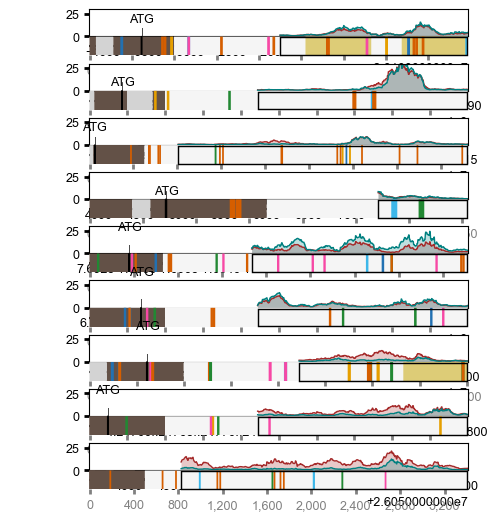

In [25]:
if __name__ == "__main__":
    import sys

    main(sys.argv[1:])